# Will my child become a smoker?



The goal of this project is to understand the social determinants of health as young people move from childhood through adolescence and determine effective health improvement interventions. 

The objective of this study is to find out which factors are determinant of tobacco use in adolescents. 


**Open Data Source:** Health Behavior in School-aged Children(HBSC)*

**Field of Study:**  Health and well-being

**Data Collection Method:** International standard questionnaire enabling cross-national comparisons


**Dataset: ** Quantitative data on key health behaviors, health indicators and the contextual social environment

**Dataset summary: **

Total number of respondents:  213595

Total number of Countries with respondents: 40 

Youngest and Oldest respondent: 10.5  years old and 16.5 years old

  Year: 2010
         
**Project Focus:**

 USA with 6274 respondents which constitues 2.9 percent of  respondents.


* Copyright (C) 2013 Health Behaviour in School-aged Children



In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
plt.style.use('fivethirtyeight')
import squarify
import numpy as np
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## DATA

In [2]:
df=pd.read_csv("../input/HBSC2010.csv")

In [3]:
df.shape

(213595, 128)

In [4]:
df.head()

,surveyyear,countryno,subregion,schoolno,classno,uniqueid,sampleweights,monhtcollect,yearcollect,sex,grade,monthbirth,yearbirth,age,agecat,breakfastwd,breakfastwe,fruits,vegetables,sweets,softdrinks,ondiet,thinkbody,bodyweight,bodyheight,MBMI,toothbr,physact60,timeexce,hourexce,tvwd,tvwe,playgamewd,playgamewe,compusewd,compusewe,triedsmoke,smoking,beer,wine,...,sistershome2,talkfather,talkstepfa,talkmother,talkstepmo,talkbrother,talksister,talkbestfriend,talksamesex,talkopposex,malefriends,femalefriends,friendsafternoon,friendsevening,emedia6m,headache,stomachache,backache,feellow,irritable,nervous,sleepdifficulty,dizzy,health,lifesat,acachieve,likeschool,studtogether,studhelpful,studaccept,schoolpressure,occupsesfa,occupsesmo,famcar,bedroom,holidays,computers,welloff,hungry,menarche
0,2010,40000,4,1,1,4000000070,1.0,5.0,2010.0,2,3.0,10.0,1994.0,15.583333,3.0,NaN,3.0,3.0,4.0,5.0,7.0,1.0,2.0,49.0,165.0,17.998163,1.0,2.0,3.0,2.0,3.0,4.0,3.0,3.0,3.0,3.0,1.0,3.0,4.0,4.0,...,NaN,3.0,5.0,2.0,5.0,3.0,5.0,2.0,2.0,2.0,4.0,2.0,6.0,2.0,5.0,4.0,4.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,7.0,3.0,3.0,2.0,2.0,2.0,2.0,4.0,4.0,3.0,2.0,2.0,3.0,2.0,4.0,15.0
1,2010,40000,2,2,2,4000000075,1.0,5.0,2010.0,1,1.0,7.0,1999.0,10.833333,1.0,NaN,3.0,1.0,1.0,4.0,4.0,3.0,2.0,40.0,150.0,17.777778,2.0,3.0,2.0,5.0,1.0,2.0,7.0,7.0,1.0,2.0,1.0,4.0,5.0,5.0,...,0.0,3.0,5.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,4.0,2.0,5.0,NaN,1.0,2.0,2.0,4.0,5.0,4.0,4.0,3.0,2.0,2.0,5.0,4.0,3.0,2.0,5.0,5.0,4.0,2.0,3.0,3.0,2.0,3.0,2.0,4.0,3.0,NaN
2,2010,40000,2,2,2,4000000076,1.0,5.0,2010.0,2,1.0,7.0,1999.0,10.833333,1.0,NaN,3.0,4.0,5.0,4.0,2.0,1.0,2.0,NaN,NaN,NaN,1.0,3.0,4.0,3.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,4.0,5.0,5.0,...,NaN,2.0,5.0,2.0,5.0,5.0,5.0,1.0,1.0,5.0,4.0,4.0,5.0,1.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,NaN,NaN,2.0,2.0,2.0,2.0,2.0,1.0,3.0,4.0,3.0,2.0,3.0,2.0,1.0,4.0,NaN
3,2010,40000,2,2,2,4000000077,1.0,5.0,2010.0,1,1.0,6.0,1999.0,10.916667,1.0,NaN,2.0,4.0,2.0,4.0,6.0,1.0,4.0,47.0,152.0,20.342798,1.0,3.0,3.0,5.0,4.0,6.0,3.0,4.0,3.0,4.0,2.0,4.0,5.0,5.0,...,0.0,1.0,3.0,1.0,3.0,5.0,5.0,1.0,1.0,3.0,4.0,4.0,3.0,0.0,5.0,5.0,4.0,5.0,3.0,2.0,2.0,2.0,5.0,1.0,7.0,1.0,3.0,2.0,3.0,3.0,3.0,4.0,4.0,2.0,2.0,1.0,4.0,2.0,4.0,NaN
4,2010,40000,2,2,2,4000000078,1.0,5.0,2010.0,1,1.0,5.0,1999.0,11.000000,1.0,NaN,3.0,7.0,4.0,5.0,3.0,1.0,4.0,36.0,148.0,16.435354,1.0,7.0,1.0,6.0,1.0,1.0,3.0,4.0,2.0,3.0,2.0,4.0,5.0,5.0,...,NaN,2.0,5.0,2.0,5.0,5.0,5.0,3.0,3.0,5.0,4.0,1.0,1.0,0.0,3.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,1.0,8.0,2.0,1.0,2.0,2.0,2.0,2.0,12.0,12.0,3.0,2.0,3.0,3.0,NaN,4.0,NaN


## Some Basic Analysis

In [5]:
print('The total number of respondents:',df.shape[0])
print('Total number of Countries with respondents:',df['countryno'].nunique())
print('Country with highest respondents:',df['countryno'].value_counts().index[0],'with',df['countryno'].value_counts().values[0],'respondents')
print('Youngest respondent:',df['age'].min(),' and Oldest respondent:',df['age'].max())

The total number of respondents: 213595
Total number of Countries with respondents: 40
Country with highest respondents: 124000 with 15919 respondents
Youngest respondent: 10.5  and Oldest respondent: 16.5


### Respondents By Country


In [6]:
df['countryno'].dtypes
df['countryno'] = df['countryno'].astype('category')
country_dic= {8000:'Albania', 40000:'Austria',51000:'Armenia',56001:'Belgium (Flemish)',56002:'Belgium (French)',100000:'Bulgaria',124000:'Canada',191000:'Croatia',203000:'Czech Republic',
              208000:'Denmark',233000:'Estonia',246000:'Finland',250000:'France',276000:'Germany',300000:'Greece',304000:'Greenland',348000:'Hungary',352000:'Iceland',372000:'Ireland',
              376000:'Israel', 380000:'Italy',428000:'Latvia',440000:'Lithuania',442000:'Luxembourg',470000:'Malta',498000:'Republic of Moldova',528000:'Netherlands',578000:'Norway',
              616000:'Poland',620000:'Portugal',642000:'Romania',643000:'Russia',703000:'Slovakia',705000:'Slovenia',724000:'Spain',752000:'Sweden',756000:'Switzerland',792000:'Turkey',
              804000:'Ukraine',807000:'Macedonia',826001:'England',826002:'Scotland',826003:'Wales',840000:'USA'}
df['country']=df['countryno'].map(country_dic)

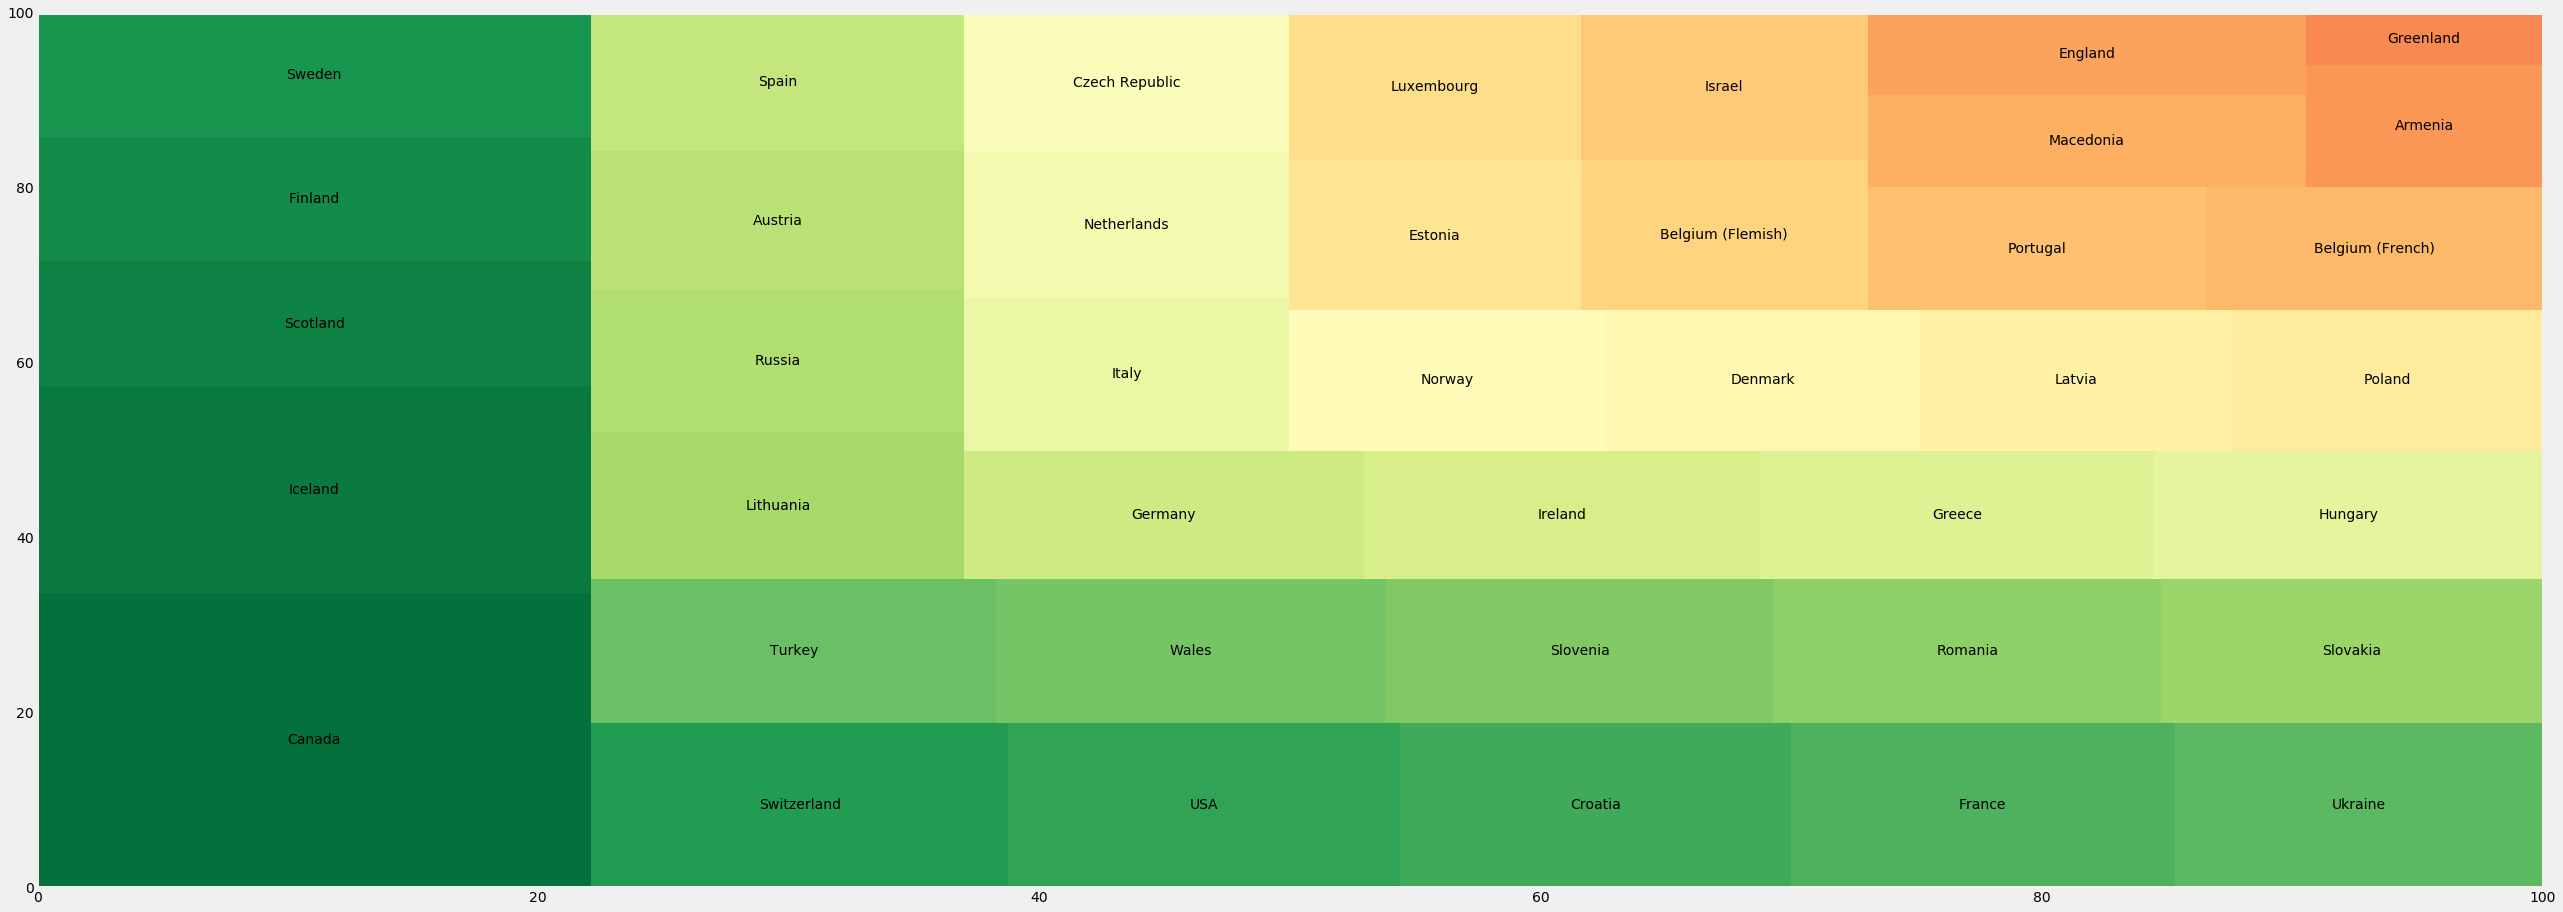

In [7]:
tree=df['country'].value_counts().to_frame()
squarify.plot(sizes=tree['country'].values,label=tree.index,color=sns.color_palette('RdYlGn_r',52))
plt.rcParams.update({'font.size':20})
fig=plt.gcf()
fig.set_size_inches(40,15)
plt.show()

#### Canada with 15919 respondents ,Iceland, Scotland, Finland and Sweden constitute maximum respondents, about 20% of the total. Greenland with 1207 respondents has the lowest number of respondents. USA with 6274 respondents constitues 2.9 percent of respondents.


## USA

#### The scope of this study is limied to the young adults in the USA. Therefore all the fololowing analysis only is done on this country

In [8]:
data= df[df['country']=='USA']

In [9]:
data.shape

(6274, 129)

## Exploratory Data Analysis

#### Data has been explored under the following categories:

#### a) Demographic Information

#### b) Family

#### c) Health behavior


 ## a) Demographic Information

### Gender Split

In [10]:
data['sex'] = data['sex'].astype('category')
sex_dic={1:'Boy',2:'Girl'} # 0 for girls and 1 for boys
data['gender']=data['sex'].map(sex_dic)

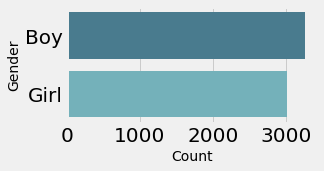

In [11]:
plt.subplots(figsize=(4,2))
ax= sns.countplot(y=data['gender'], order=data['gender'].value_counts().index, palette='GnBu_d')
ax.set_xlabel('Count',fontsize=14)
ax.set_ylabel('Gender',fontsize=14)
plt.show()

#### The number of girls who took part in this survey is slightly less than boys.


### Body Image and BMI Status 
#### Physical apperance seems to be an  important factor for teenagers. In this section we have a look at the distribution of BMI in the respondents and their own body image.

In [12]:
print('Maximum BMI',round(data['MBMI'].dropna().max(),2))
print('Minimum BMI',data['MBMI'].dropna().min())
print('Median BMI',round(data['MBMI'].dropna().median(),2))

Maximum BMI 44.7
Minimum BMI 0.0
Median BMI 20.37


#### The minimum BMI cannot be true. We need to check for zero weights. 

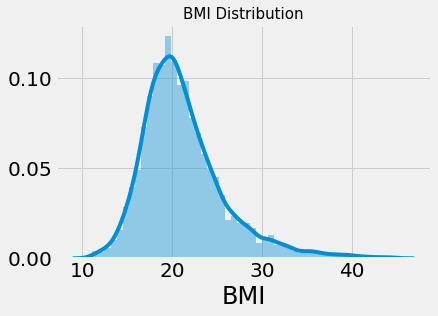

In [13]:
plt.subplots(figsize=(6,4))
bmi=data[data['MBMI']>0]
ax= sns.distplot(bmi['MBMI'])
ax.set(xlabel='BMI')
plt.title('BMI Distribution',size=15)
plt.show()

Converting BMI to weight category based on the following cutoff points:

*Underweight	Less than the 5th percentile (0)

*Normal or Healthy Weight	5th percentile to less than the 85th percentile (1)

*Overweight	85th to less than the 95th percentile (2)

*Obese	Equal to or greater than the 95th percentile (3)

In [14]:
q5=data.groupby('sex')['MBMI'].quantile(q=.05)
print('5% quntile: ', round(q5,1))
q85=data.groupby('sex')['MBMI'].quantile(q=.85)
print('85% quntile: ', round(q85,1))
q95=data.groupby('sex')['MBMI'].quantile(q=.95)
print('95% quntile: ', round(q95,1))

5% quntile:  sex
1    15.2
2    15.2
Name: MBMI, dtype: float64
85% quntile:  sex
1    25.6
2    25.0
Name: MBMI, dtype: float64
95% quntile:  sex
1    30.4
2    30.1
Name: MBMI, dtype: float64


In [15]:
data.loc[ data['MBMI'] <15, 'BMI_status']= 'Underweight'
data.loc[(data['MBMI'] >= 15) & (data['MBMI'] < 25), 'BMI_status'] = 'Healthy'
data.loc[(data['MBMI'] >= 25) & (data['MBMI'] <30), 'BMI_status'] = 'Overweight'
data.loc[ data['MBMI'] >= 30, 'BMI_status'] = 'Obese'

In [16]:
body_dic={1:'Underweight',2:'Underweight',3:'Healthy',4:'Overweight',5:'Obese'} # categorizing the data in the same way as BMI_status for comparison
data['thinkbody']=data['thinkbody'].map(body_dic)

In [17]:
data['Body_image'] = data['thinkbody']

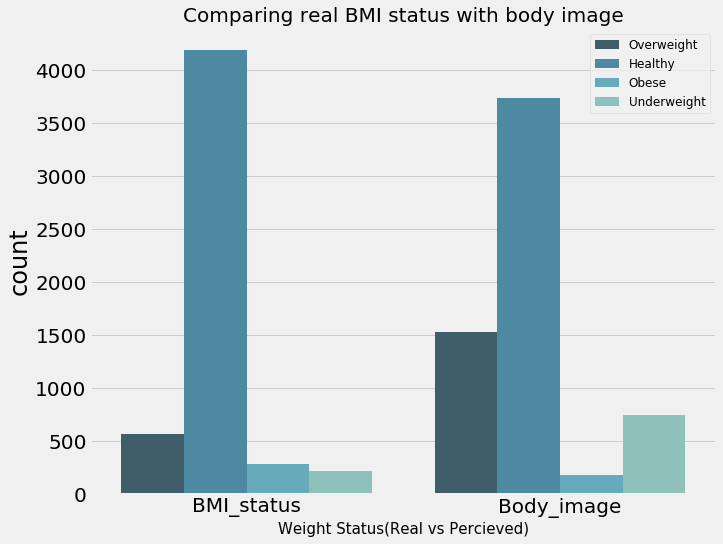

In [18]:
df1=data[['BMI_status', 'Body_image']]
f,ax=plt.subplots(figsize=(10,8))
sns.countplot(x="variable", hue="value", data=pd.melt(df1), palette="GnBu_d")
ax.set_title('Comparing real BMI status with body image', size=20)
ax.set_xlabel('Weight Status(Real vs Percieved)', size= 15)
plt.legend(prop={'size': 12})
plt.show()

#### It seems most kids have healthy weight status but the number of kids who think they are overweight or underweight are more than real numbers.

### Age

In [19]:
age_dic={1:11,2:13,3:15} 
data['agecat']=data['agecat'].map(age_dic)

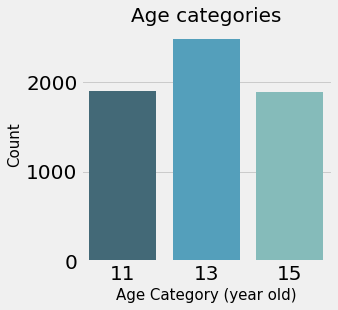

In [20]:
plt.subplots(figsize=(4,4))
ax=sns.countplot(data['agecat'], palette='GnBu_d')
plt.title('Age categories',size=20)
ax.set_xlabel('Age Category (year old)', size=15)
ax.set_ylabel('Count', size=15)
plt.show()

#### The number of kids between the age of 12.5 and 13.5 is slightly more than other age groups. 


## b) Family

### Socio Economic Status(SES) of Parents 

#### Scaling is from 1 for high SES status to 5 for low SES status. Number 6-12 represent ouside these categories  or unknown.
#### 6-12 (JOB, SES NOT CLASS), (SICK,RETIRED, STUD.),(LOOKING FOR JOB),(HOME WORKING) , (DON'T KNOW) , (DON'T HAVE OR SEE) ,(NOT CLASSIFIABLE)

In [21]:
ses_dic={1:1,2:2,3:3,4:4,5:5,6:6,7:6,8:6,9:6,10:6,11:6,12:6} # number 6-12 is categorized as number 6 (No information)
data['sesfa']=data['occupsesfa'].map(ses_dic)
data['sesmo']=data['occupsesmo'].map(ses_dic)

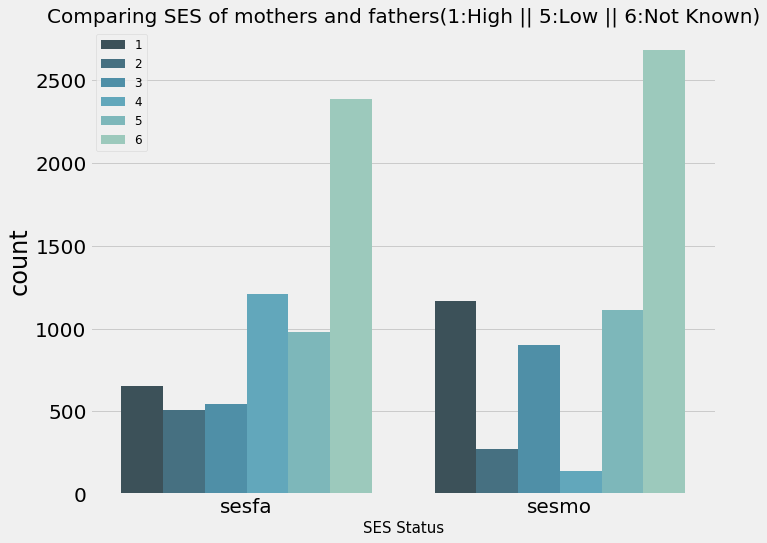

In [22]:
df1=data[['sesfa', 'sesmo']]
f,ax=plt.subplots(figsize=(10,8))
sns.countplot(x="variable", hue="value", data=pd.melt(df1), palette='GnBu_d')
ax.set_title('Comparing SES of mothers and fathers(1:High || 5:Low || 6:Not Known)', size=20)
ax.set_xlabel('SES Status', size= 15)
plt.legend(prop={'size': 12})
plt.show()

#### It seems many of data on SES is missing (Category(6)).  Most fathers are in SES status below the average and mothers have either very high or very low SES. 

### Family Well off

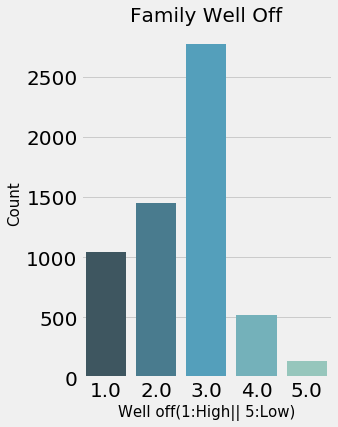

In [23]:
f,ax=plt.subplots(figsize=(4,6))
sns.countplot(x=data['welloff'],palette='GnBu_d')
ax.set_title('Family Well Off', size=20)
ax.set_xlabel('Well off(1:High|| 5:Low)', size=15)
ax.set_ylabel('Count', size=15)
plt.show()

#### It seems family well off represents a more concrete description of the economic status of families compared to SES of parents. Most families in the US are in average category or lower the average. 

### Living with Parents

#### Data provided lots of features each one asking if the youth lives with a certain related person (e.g. mother, father, step-mother, step-father, grandmother, granddfather, another person, foster facility, ...). In this section, I extracted data so that it provides information on whether the youth lives with both parents, one of the parents or none of the parents. 

In [24]:
family_dic={1:1,2:0} 
data['fatherhome1']=data['fatherhome1'].map(family_dic)
data['motherhome1']=data['motherhome1'].map(family_dic)
data['mom_dad']= data['fatherhome1']+data['motherhome1']

In [25]:
data['mom_dad']= np.where(data['mom_dad'] > 1, 2, 
         (np.where(data['mom_dad'] < 1, 0, 1))) 

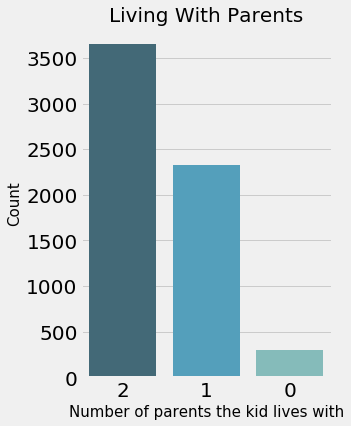

In [26]:
f,ax=plt.subplots(figsize=(4,6))
sns.countplot(x=data['mom_dad'],ax=ax,order=data['mom_dad'].value_counts().index,palette="GnBu_d" )
ax.set_title('Living With Parents', size =20)
ax.set_ylabel('Count', size=15)
ax.set_xlabel('Number of parents the kid lives with', size=15)
plt.show()

#### Most kids live with their both parents or their mom or dad. About 250 kids live with someone other than their parents. 

## c) Health Behavior

###  Physical Activity

In [27]:
pa_dic={0:'Low',1:'Low',2:'Medium',3:'Medium',4:'Medium',5:'High',6:'High',7:'High'} # Low: 0 or 1 day/week, Medium: 2,3 or 4 days/week, High: 5,6 or 7 days/week
data['physact60']=data['physact60'].map(pa_dic)

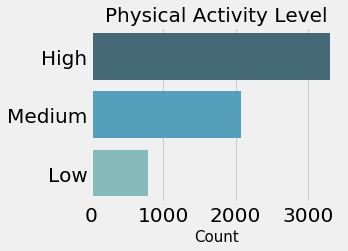

In [28]:
f,ax=plt.subplots(figsize=(4,3))
sns.countplot(y=data['physact60'],ax=ax,order=data['physact60'].value_counts().index,palette='GnBu_d')
ax.set_title('Physical Activity Level', size= 20)
ax.set_xlabel('Count', size=15)
ax.set_ylabel('', size=15)
plt.show()

#### It seems the number of kids who get medium to high level of physical activity is more than the sedentary ones.

### Screen Time

In [29]:
data['tvwd'] = np.where(data['tvwd']>2, '> 2 hours per day', '< 2 hours perday')
data['playgamewd']= np.where(data['playgamewd']>2, '> 2 hours per day', '< 2 hours perday')

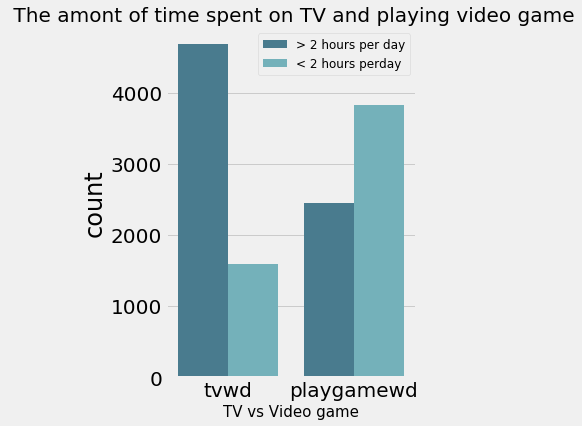

In [30]:
df2=data[['tvwd', 'playgamewd']]
f,ax=plt.subplots(figsize=(4,6))
sns.countplot(x="variable", hue="value", data=pd.melt(df2), palette="GnBu_d")
ax.set_title(' The amont of time spent on TV and playing video game', size=20)
ax.set_xlabel('TV vs Video game', size= 15)
plt.legend(prop={'size': 12})
plt.show()

#### Watching TV and playing computer games do not follow the same pattern therefore we keep both of them in the analysis.

### Feeling Low or Nervous

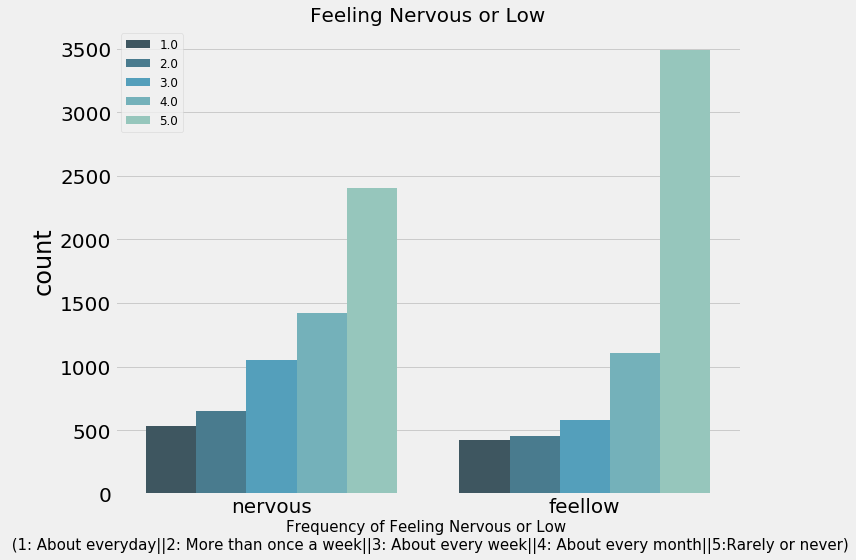

In [34]:
df5=data[['nervous', 'feellow']]
f,ax=plt.subplots(figsize=(10,8))
sns.countplot(x="variable", hue="value", data=pd.melt(df5), palette='GnBu_d')
ax.set_title('Feeling Nervous or Low', size=20)
ax.set_xlabel('Frequency of Feeling Nervous or Low \n (1: About everyday||2: More than once a week||3: About every week||4: About every month||5:Rarely or never)', size=15)
plt.legend(prop={'size': 12})
plt.show()

####  It seems teenagers are more likely to get nerves than depressed. 

 #### The number of kids who feel low or nervous frequently are considerable. 

### Bullying Others and Physical Fight

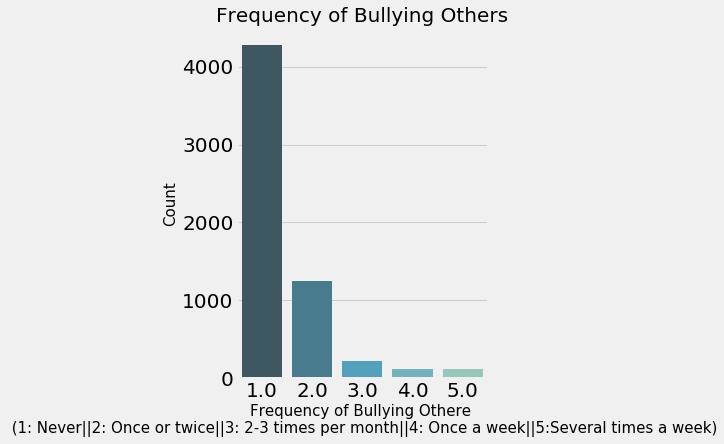

In [35]:
f,ax=plt.subplots(figsize=(4,6))
sns.countplot(x=data['bulliedothers'],ax=ax,order=data['bulliedothers'].value_counts().index,palette="GnBu_d" )
ax.set_title('Frequency of Bullying Others', size =20)
ax.set_ylabel('Count', size=15)
ax.set_xlabel('Frequency of Bullying Othere \n (1: Never||2: Once or twice||3: 2-3 times per month||4: Once a week||5:Several times a week)', size=15)
plt.show()

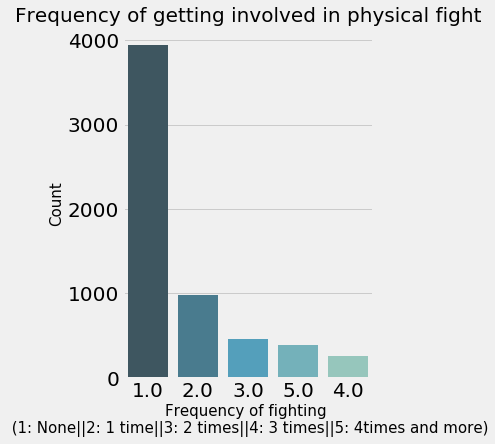

In [36]:
f,ax=plt.subplots(figsize=(4,6))
sns.countplot(x=data['fight12m'],ax=ax,order=data['fight12m'].value_counts().index,palette="GnBu_d" )
ax.set_title('Frequency of getting involved in physical fight', size =20)
ax.set_ylabel('Count', size=15)
ax.set_xlabel('Frequency of fighting \n (1: None||2: 1 time||3: 2 times||4: 3 times||5: 4times and more)', size=15)
plt.show()

 #### It seems in comparison the number of kids that bully others are less than those who get involved in physical fight. 
####  The number of kids who bully others occasionally is considerable.
####  The number of kids occasionally or frequently get involved in physical fight cannot be neglected.

### Target Variable (Tried Smoking)

In [37]:
smoking_dic={1:'Smoked',2:'Never_Smoked'} # 1 for tried smoking 2 for never tried smoking
data['triedsmoke'] = data['triedsmoke'].astype('category')
data['target']=data['triedsmoke'].map(smoking_dic)

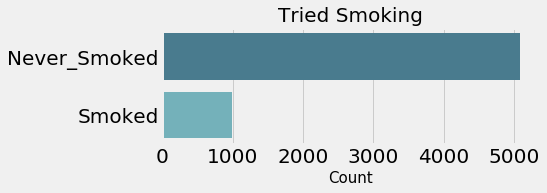

In [38]:
f,ax=plt.subplots(figsize=(6,2))
sns.countplot(y=data['target'],ax=ax,order=data['target'].value_counts().index,palette="GnBu_d")
ax.set_title('Tried Smoking', size=20)
ax.set_ylabel('', size=15)
ax.set_xlabel('Count', size=15)
plt.show()

#### The graph shows this is an imbalanced class problem. As it was expected there are far more nonsmokers than smokers. SMOTE technique is used to weight the classes by their representation in the data to reflect this imbalance.


## Pre-processing data

### Data Cleaning/Feature Engineering

#### In each category, the same data has been collected in different ways addressing different aspects of one main feature. Having  different levels of details addressing the same feature required the analyst to engineer and/or combine  the features based on the objective of the project (e.g. Who does the child live with?). 

 #### The outcome of this study is to predict the probability of the child to try smoking given the demographic and family information and their habit. However, in addition to smoking,  the dataset provide information on teenagers use of drugs and alcohol as well.  These data could be the target variable for another studies. 


In [39]:
# remove data that is not needed
data=data.drop(['surveyyear',  'countryno', 'classno', 'sampleweights', 'monhtcollect',  'yearcollect','sex', 'grade',  'monthbirth',
 'yearbirth', 'age', 'breakfastwd', 'breakfastwe', 'fruits', 'vegetables', 'sweets', 'softdrinks', 'ondiet', 'bodyweight',
 'bodyheight', 'MBMI', 'toothbr', 'timeexce',  'hourexce', 'tvwe',  'playgamewe',  'compusewd',  'compusewe',  'triedsmoke',
 'smoking',  'beer', 'wine',  'spirits',  'alcopops',  'otheralco',  'drunk',  'agealco',  'agedrunk',  'agecigarette',
 'smoke30d',  'drink30d',  'drunk30d',  'cannabisltm',  'cannabis12m',  'cannabis30d',  'hadsex',  'agesex',  'contraceptnever',
 'contraceptnomet',  'contraceptpill',  'contraceptcondom',  'contraceptwithdraw',  'contraceptother',  'contraceptnotsure',
 'condomuse', 'stepmohome1',  'stepfahome1', 'grandmohome1', 'grandfahome1', 'elsehome1',  'brothershome1',  'sistershome1',
 'havehome2',  'stayhome2',  'motherhome2',  'fatherhome2',  'stepmohome2',  'stepfahome2',  'grandmohome2',  'grandfahome2',
 'fosterhome2',  'elsehome2',  'brothershome2',  'sistershome2', 'talkstepfa',  'talkmother',  'talkstepmo',
 'talkbrother',  'talksister',  'talkbestfriend',  'talksamesex', 'talkfather',  'talkopposex',  'malefriends',  'femalefriends',
 'friendsafternoon','headache',  'stomachache', 'backache',  'irritable', 'sleepdifficulty',  'dizzy', 'lifesat', 
 'studtogether',  'studhelpful',  'studaccept',  'schoolpressure',  'occupsesfa',  'occupsesmo',  'famcar',  'bedroom',  'holidays',
 'computers', 'hungry', 'menarche',  'country', 'sesfa',  'sesmo', 'injured12m', 'fosterhome1','motherhome1',  'fatherhome1',
 'friendsevening','subregion', 'schoolno','thinkbody'
 ], axis=1)

In [40]:
pa_dic={'Low':1,'Medium':2,'High':3} 
data['physact60']=data['physact60'].map(pa_dic)
screen_dic={'> 2 hours per day':1, '< 2 hours perday':0}
data['tvwd']=data['tvwd'].map(screen_dic)
data['playgamewd']=data['playgamewd'].map(screen_dic)
sex_dic={'Boy':1,'Girl':0} 
data['gender']=data['gender'].map(sex_dic)
body_dic={'Underweight':1,'Healthy':2,'Overweight':3,'Obese':4} 
data['BMI_status']=data['BMI_status'].map(body_dic)
data['Body_image']=data['Body_image'].map(body_dic)
smoking_dic={'Smoked':1,'Never_Smoked':0} 
data['target']=data['target'].map(smoking_dic)

In [41]:
data.rename(columns={'uniqueid':'id'}, inplace = True) 

In [42]:
data=data.set_index('id')

In [43]:
#drop duplicate rows
data = data.drop_duplicates()

### Filling Missing Values

In [44]:
data.isnull().sum()

agecat              0
physact60         112
tvwd                0
playgamewd          0
fight12m          232
beenbullied       234
bulliedothers     292
emedia6m          133
feellow           211
nervous           216
health             74
acachieve         201
likeschool        153
welloff           348
gender              0
BMI_status       1002
Body_image         79
mom_dad             0
target            198
dtype: int64

In [45]:
data[data.isnull().any(axis=1)] =  data[data.isnull().any(axis=1)].apply(lambda x:x.fillna(x.value_counts().index[0]))

#### Misssing data were filled with the most frequent value in each column.

## Train and Test Split

In [46]:
msk= np.random.rand(len(data))<0.8

In [47]:
train=data[msk]

In [48]:
test=data[~msk]

## Imbalanced dataset

In [49]:
print('Never-Smoked', train['target'].value_counts()[0], 'number of rows')
print('Smoked', train['target'].value_counts()[1], 'number of rows')

Never-Smoked 4222 number of rows
Smoked 808 number of rows


In [50]:
print('Never-Smoked', round(train['target'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Smoked', round(train['target'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

Never-Smoked 67.47 % of the dataset
Smoked 12.91 % of the dataset


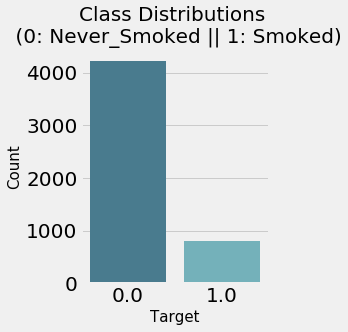

In [51]:
f,ax=plt.subplots(figsize=(3,4))
sns.countplot('target', data=train, palette="GnBu_d")
ax.set_title('Class Distributions \n (0: Never_Smoked || 1: Smoked)', size=20)
ax.set_ylabel('Count', size=15)
ax.set_xlabel('Target', size=15)
plt.show()

In [52]:
X_train = train.drop(["target"], axis=1)
y_train= train["target"]

In [53]:
print(len(y_train[y_train==1]), len(y_train[y_train==0]))

808 4222


### Resampling of data using SMOTE Technique

#### Synthetic Minority Oversampling Technique (SMOTE) is used to increase the number of cases in the dataset in a balanced way. The module works by generating new instances from existing minority cases (smoked) without changing the number of majority cases*.  In this method, the algorithm takes samples of the feature space for each target class and its nearest neighbors, and generates new examples that combine features of the target case with features of its neighbors.

#### In this project SMOTE technique is used to increase the number of cases that smoke from 798 to  4221 which is the same number as those cases who never smoked. 


In [54]:
from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=0)
X_train ,y_train= oversampler.fit_sample(X_train, y_train)

In [55]:
print(len(y_train[y_train==1]), len(y_train[y_train==0]))

4222 4222


### Normalization

#### The selected features are ordinal and bi-nominal in data type. The level of ordinal features is associated to the frequency of the behavior in question. Therefore, different scales exists. Normalization based on min and max level has been done in order to make the comparison between different features possible.  


In [56]:
from sklearn.preprocessing import Normalizer
scaler=Normalizer().fit(X_train)
X_train= scaler.transform(X_train)

## Model Selection

#### Different classification models has been performed to compare the accuracy of the result.
####  Cross-validation method is used to select the best performing model.
####  Randomized parameter optimization has been performed to tune the hyperparameters in Random forest classifier and KNeighbor classifier. 

In [58]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_validate

### Parameter tuning for K-Neighbor Classifier

In [59]:
#knn= KNeighborsClassifier()
#k_range=range(1,31)
#param_dist= dict(n_neighbors=k_range)
#rand=RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy',n_iter=2, random_state=5, n_jobs=-1)
#rand.fit(X_train,y_train)

#print(rand.best_score_)
#print(rand.best_params_)

### Parameter tuning for Random Forest Classifier

In [60]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
               #'max_features': max_features,
               #'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap}
#print(random_grid)
#{'bootstrap': [True, False],
 #'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 #'max_features': ['auto', 'sqrt'],
 #'min_samples_leaf': [1, 2, 4],
 #'min_samples_split': [2, 5, 10],
 #'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [61]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train)

In [62]:
#rf_random.best_params_

### Classifiers

In [63]:
classifiers = [
    KNeighborsClassifier(12),
    DecisionTreeClassifier(),
    RandomForestClassifier(bootstrap= False,max_depth= 50,max_features= 'auto', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1000),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
    ]


# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy",  "Recall", "precision"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    acc= cross_val_score(clf, X_train,y_train, cv=10, scoring='accuracy').mean()
    rc=cross_val_score(clf, X_train,y_train, cv=10, scoring='recall').mean()
    pr=cross_val_score(clf, X_train,y_train, cv=10, scoring='precision').mean()
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    print("Accuracy: {:.4%}".format(acc))
    
    print("Recall: {}".format(rc))
    print("Precision: {}".format(pr))
    
    log_entry = pd.DataFrame([[name, acc*100, rc,pr]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)


KNeighborsClassifier
****Results****
Accuracy: 77.9387%
Recall: 0.9517063852195443
Precision: 0.7078135782849072
DecisionTreeClassifier
****Results****
Accuracy: 84.0643%
Recall: 0.8622516890188565
Precision: 0.8256741135768664
RandomForestClassifier
****Results****
Accuracy: 92.5089%
Recall: 0.9307188553886144
Precision: 0.9229074274431038
GradientBoostingClassifier
****Results****
Accuracy: 85.0033%
Recall: 0.8293956505663674
Precision: 0.8598896726426934
GaussianNB
****Results****
Accuracy: 72.0997%
Recall: 0.7041976180072378
Precision: 0.7290242147969339
LinearDiscriminantAnalysis
****Results****
Accuracy: 72.8344%
Recall: 0.7492022677108892
Precision: 0.7190257914364697
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 74.5653%
Recall: 0.7667663832028054
Precision: 0.7345138072287465


#### Random Forest Classifier is the best performed model.

In [64]:
favorite_clf = RandomForestClassifier(bootstrap= False,max_depth= 50,max_features= 'auto', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 1000)
favorite_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Cross validation scores: [0.82269504 0.79905437 0.95260664 0.95971564 0.96327014 0.96563981
 0.9478673  0.94312796 0.94668246 0.94905213]


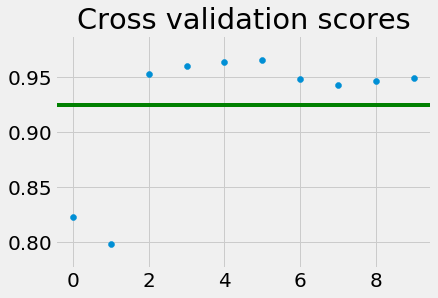

In [65]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=favorite_clf,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)

print('Cross validation scores: %s' % scores)

import matplotlib.pyplot as plt
plt.title('Cross validation scores')
plt.scatter(np.arange(len(scores)), scores)
plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
plt.show()

#### The result of cross-validation on the best performed model shows that in 2 of the segments, the model may be a bit complex, and so tends to “over-fit” to spurious properties of the data.  Parameter tuning had reduced the over fitting substantially.  At this point having more training data could help to overcome the complexity of the model.

In [66]:
print(np.mean(scores))

0.9249711494291508


### Feature Importance

#### Random Forests are used for getting the most important features in the model. The reason is because the tree-based strategies used by random forests naturally ranks by how well they improve the purity of the node. Nodes with the greatest decrease in impurity happen at the start of the trees, while notes with the least decrease in impurity occur at the end of trees. 

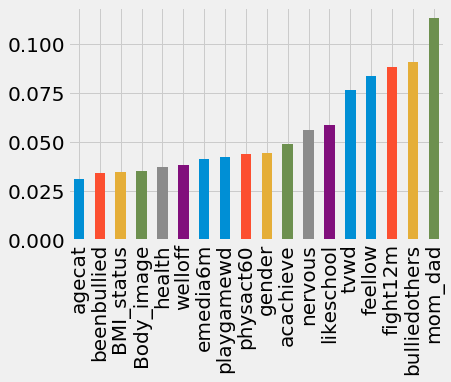

In [67]:
features= ['agecat', 'physact60', 'tvwd', 'playgamewd', 'fight12m', 'beenbullied',
       'bulliedothers', 'emedia6m', 'feellow', 'nervous', 'health',
       'acachieve', 'likeschool', 'welloff', 'gender', 'BMI_status',
       'Body_image', 'mom_dad']
pd.Series(index =features, data = favorite_clf.feature_importances_).sort_values().plot(kind = 'bar')

#### The Tree-based strategy* is used to rank the top 10 features as follows:
 
1. Living with parents
2. Watching TV
3. Feeling low
4. Getting involved in physical fight
5. Bullying others
6. Feeling nerves
7. Physical activity
8. Academic achievement
9. Playing video game
10. Gender


## Evaluation

### Features and Target  Variables

In [72]:
X_test =test.drop(["target"], axis=1)
y_test= test["target"]

### Normalizing Test Features

In [69]:
from sklearn.preprocessing import Normalizer
X_test= scaler.transform(X_test)

### Prediction and Evaluation

In [70]:
predicted = cross_val_predict(favorite_clf, X_test, y_test, cv=10)
metrics.accuracy_score(y_test, predicted) 

0.8436482084690554

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predicted)

array([[1003,   40],
       [ 152,   33]])

## Conclusion

#### Accuracy of the model to predict the probability of children trying tobacco : 0.85

#### Confusion Metric: 


a. True Negative: 1011

b. True Positive: 22

c. False Negative: 149

d. . False Positive: 35

#### The confusion metric shows that:

1. The model 84.88%  correctly predicts the probability of  whether or not the child is at high risk of smoking ((TP+TN)/Total
2. 12.86 % of the kids who are at high risk of using tobacco can be identified by this model (TP/(TP+FN)).
3. The cost of the model is 3.35% which is related to the cases that model falsely predicted to be at high risk (FP/(TN+FP))

#### The feature importance indicates that:
1. Whether the child live with both parents, just one parent or none of them is the most important feature affecting the risk of using tobacco in adolescents. 
2. Whether the child spends more that the recommended limit of 2 hours on watching TV constitutes the second indicator. 
3. Feeling low or depressed is the third most important indicator. 
4. Getting involved in physical fight and bullying others are some of the other symptoms of those at risk
5.  Feeling nerves frequently is another characteristic of those at high risk.
6. Whether or not the child is involved in regular physical activity is another important factor that should be considered.


## Next Step

#### **Intervention Recommendation:**

The model could identify 12.86 % of the kids who are at high risk of using tobacco. This information could help the guardian and educators to provide Junior Youth Empowerment programs for those at risk.

The program should address the social determinants identified in the study as followed: 

1.  Engaging children in active, positive activities afterschool in place of the current passive habit of watching TV.
2.  Connecting the children with social workers at school to deal with depression.
3.  Engaging the kids with moderate to vigorous physical activity on a daily basis in place of physical fighting.
4.  Educating the children about mindfulness to help them with anxiety.
5.  Educating children about the impacts of bullying on the bully and the person being bullied and implementing the zero bullying policy. 

#### **Further Study:**

Model cross-validation shows some variations exist between the accuracy of best performed model. This issue can be addressed by more feature engineering and providing additional data to overcome the probable complexity of the data.  
The data collected by HBSC enables cross-national comparison between different countries. Therefore, it would be appropriate to use the whole data or the data related to each region ( North America, Europe) for more accurate analysis. 

The data does not provide information about the health behavior of the adults child live with. Studies shows that this could be one of the main factors affecting kids behaviors. 
